## Welcome and Introduction
For this project, I'll be attempting the Kaggle [Titanic -Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic) competition.

The objective here is to train a Machine Learning model on the data of a subset of the passengers that were onboard the Titanic, and then predict from another set of passengers, those that survived and those that didn't.

The data consists of two csv files, train.csv and test.csv, and the difference in columns is that train.csv contains a survival column, while test.csv doesn't

## Imports

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import random
import zipfile
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import seaborn as sns

from tqdm import tqdm
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.io import read_image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files




## Fetch dataset
Fetch dataset from kaggle

In [ ]:
if not os.path.exists("kaggle.json") and not os.path.exists(".kaggle/kaggle.json"):
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
if not os.path.exists("dataset"):
    with zipfile.ZipFile("titanic.zip", 'r') as zip_ref:
        zip_ref.extractall("dataset")

## Verify data

In [ ]:
dataset_path = './dataset/'

# List and print the contents of the directory
contents = os.listdir(dataset_path)
print("Contents of the directory:", dataset_path)
for item in contents:
    print(item)

Contents of the directory: ./dataset/
gender_submission.csv
test.csv
train.csv


## Exploratory Data Analysis
Let's explore the data to understand it's shape and structure

In [ ]:
train_path = os.path.join(dataset_path, 'train.csv')
data = pd.read_csv(train_path)
#test_path = os.path.join(dataset_path, 'test.csv')

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [ ]:
print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [ ]:
# Display all columns and their null value counts
null_counts = data.isnull().sum()

# Print column names and null counts
print("Columns and their null value counts:\n")
print(null_counts)

Columns and their null value counts:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


View of the distribution of people by Sex

Sex
male      577
female    314
Name: count, dtype: int64


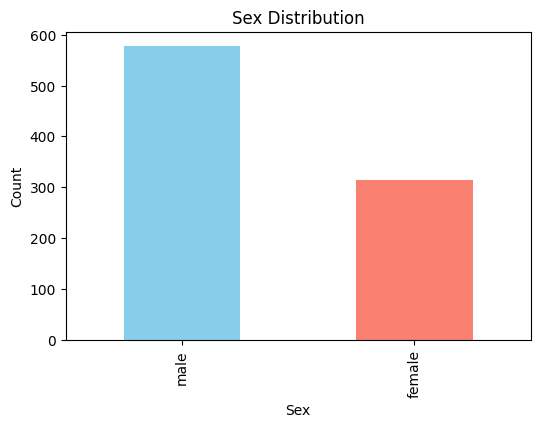

In [ ]:
sex_data = data['Sex'].value_counts()
print(sex_data)

# Plot the distribution
plt.figure(figsize=(6, 4))
sex_data.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

Let's view the age distribution

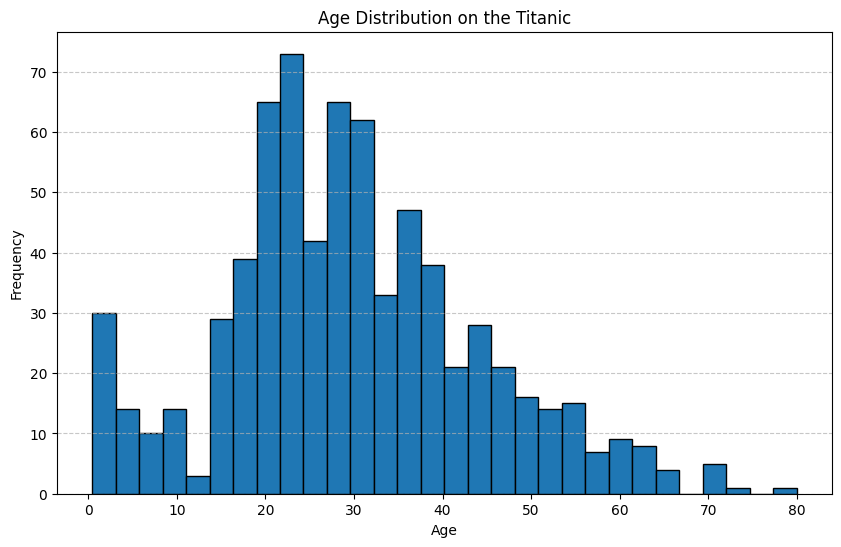

In [ ]:
age_data = data['Age'].dropna()

# Plot Age distribution
plt.figure(figsize=(10, 6))
plt.hist(age_data, bins=30, edgecolor='black')
plt.title("Age Distribution on the Titanic")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Pclass
1    216
2    184
3    491
Name: count, dtype: int64


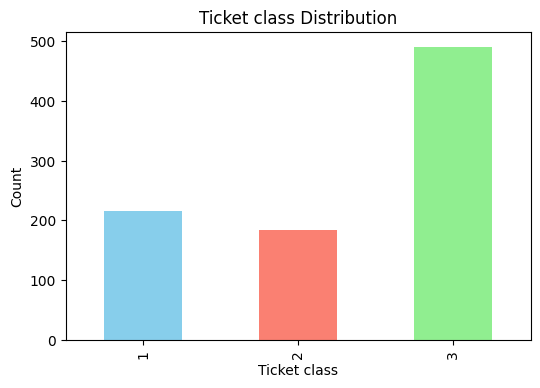

In [ ]:
pclass_data = data['Pclass'].value_counts().sort_index()
print(pclass_data)

# Plot the distribution
plt.figure(figsize=(6, 4))
pclass_data.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Ticket class Distribution')
plt.xlabel('Ticket class')
plt.ylabel('Count')
plt.show()

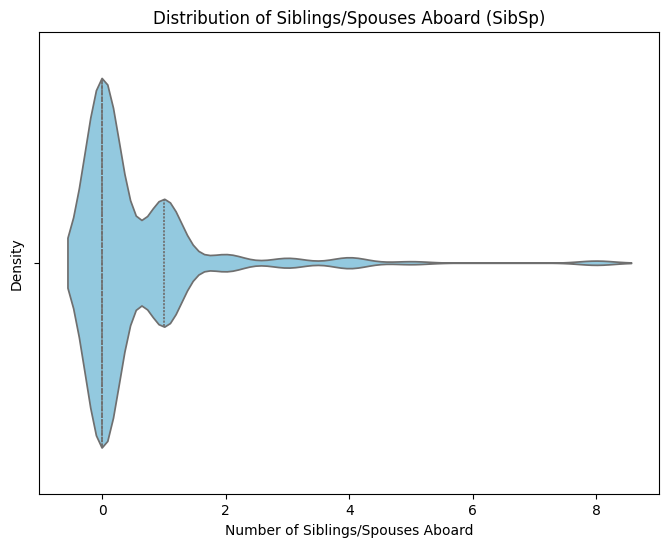

In [ ]:
plt.figure(figsize=(8, 6))

# Create a violin plot for SibSp
sns.violinplot(x=data['SibSp'], inner="quartile", color="skyblue")

# Add title and labels
plt.title("Distribution of Siblings/Spouses Aboard (SibSp)")
plt.xlabel("Number of Siblings/Spouses Aboard")
plt.ylabel("Density")

# Show the plot
plt.show()

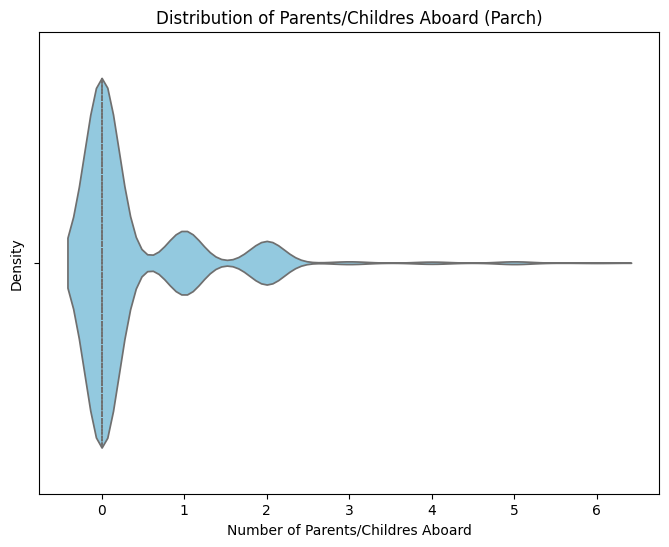

In [ ]:
plt.figure(figsize=(8, 6))

# Create a violin plot for SibSp
sns.violinplot(x=data['Parch'], inner="quartile", color="skyblue")

# Add title and labels
plt.title("Distribution of Parents/Childres Aboard (Parch)")
plt.xlabel("Number of Parents/Childres Aboard")
plt.ylabel("Density")

# Show the plot
plt.show()

Embarked
C    168
Q     77
S    644
Name: count, dtype: int64


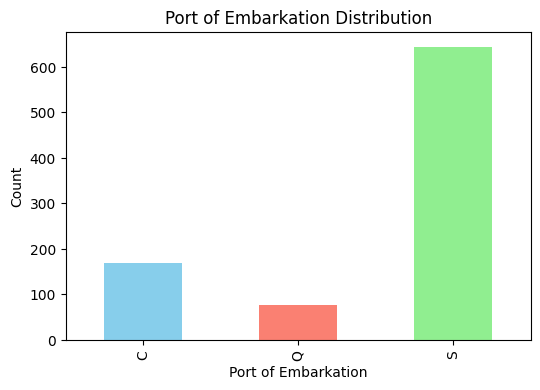

In [ ]:
pclass_data = data['Embarked'].value_counts().sort_index()
print(pclass_data)

# Plot the distribution
plt.figure(figsize=(6, 4))
pclass_data.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Port of Embarkation Distribution')
plt.xlabel('Port of Embarkation')
plt.ylabel('Count')
plt.show()

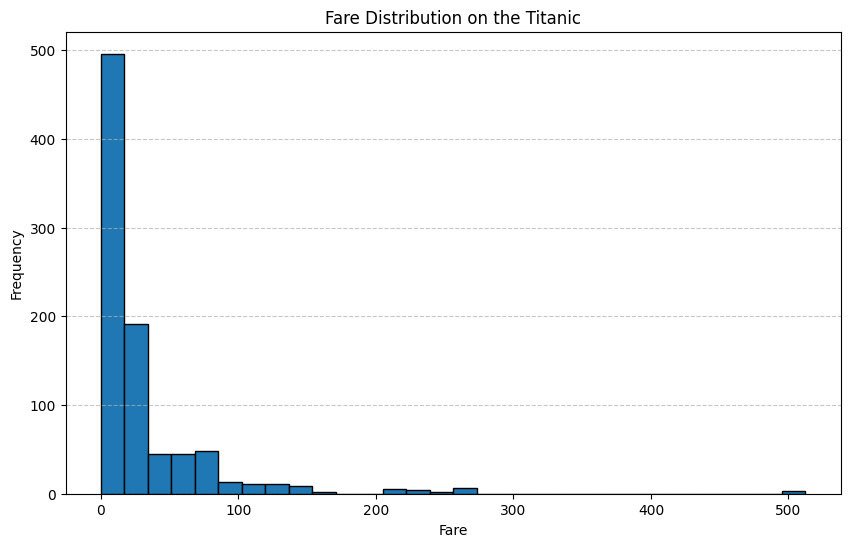

In [ ]:
# Plot Fare distribution
plt.figure(figsize=(10, 6))
plt.hist(data['Fare'], bins=30, edgecolor='black')
plt.title("Fare Distribution on the Titanic")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Preprocess the data.
Now we have an understanding of the contents of each column and spread.

The actions we'll take include
* Age - Fill missing values with the median of the group
* Convert Sex and Embarked to numerical values since they are categories (M/F and C/Q/S respectively).
* Drop Cabin (it's nearly all null)
* Drop Name (It could be fun to see if passengers what name's are more likely to be saved, but it doesn't seem like it could have been a factor during evacuation)
* Ticket (We have no context on what the Ticket number might represent)

In [ ]:
data['Age'] = data['Age'].fillna(data['Age'].median())


# Encode categorical variables
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])
data['Embarked'] = label_encoder.fit_transform(data['Embarked'])

In [ ]:
data = data.drop(['Cabin', 'Ticket', 'Name'], axis=1)

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 62.8 KB
None


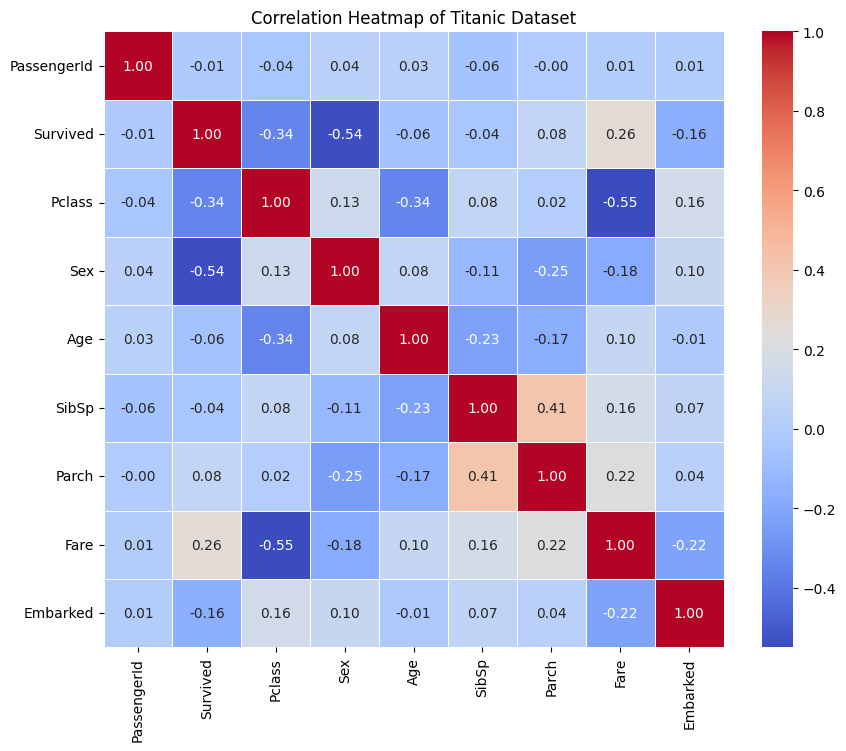

In [ ]:
correlation_matrix = data.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Titanic Dataset")

plt.show()

## Analysis
From this correlation matrix, we can see that the two main determinants for a person's survival seem to be their Sex and if they had a Sibling/Spouse on board.

In [ ]:
def plot_model_histories(histories, model_names):
    """
    Plots training and validation loss and accuracy for multiple models.

    Args:
        histories (list): List of Keras History objects.
        model_names (list): List of names for the corresponding models.

    Returns:
        None
    """
    # Set consistent colors for each model
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

    # Initialize the figure
    plt.figure(figsize=(12, 6))

    # Loss Comparison
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        color = colors[i % len(colors)]  # Cycle colors if there are many models
        plt.plot(history.history['loss'], label=f'{model_names[i]} Loss', color=color)
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{model_names[i]} Val Loss', color=color)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Comparison
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        color = colors[i % len(colors)]  # Cycle colors if there are many models
        plt.plot(history.history['accuracy'], label=f'{model_names[i]} Accuracy', color=color)
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{model_names[i]} Val Accuracy', color=color)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_training_history(history, title="Training and Validation Metrics"):
    """
    Plots training and validation loss and accuracy from a model's history object.

    Parameters:
    - history: History object returned by model.fit()
    - title: Title for the overall figure (default: "Training and Validation Metrics")
    """
    # Extract metrics
    epochs = range(1, len(history.history['loss']) + 1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot Loss
    plt.figure(figsize=(12, 6))

    # Subplot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, linestyle='--', label='Training Loss', color='green')
    plt.plot(epochs, val_loss, linestyle='--', label='Validation Loss', color='orange')
    plt.plot(epochs, accuracy, label='Training Accuracy', color='green')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
    plt.title("Model Loss and Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.grid()

    # Add overall title and show the plots
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for title
    plt.show()

## Train, Test Split

In [ ]:
# Select features and target variable
features = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
target = data['Survived']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)


## Neural Network Architecture
* Input takes the number of features in X_train
* A Dense layer with 32 neurons (this is an arbitrary first choice to test the architecture), transforms the input features to 32 neurons with ReLU
* A Dense layer with 16 neurons to help focus and reduce overfitting
* Dense Output with sigmoid activation for binary classification

This is a simple Neural Network with a little complexity to dip our feet in the challenge. I'm intentionally starting with a simple model and the aim is to scale up if necessary.


In [ ]:
# Build the neural network model
model01 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
# Compile the model
model01.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



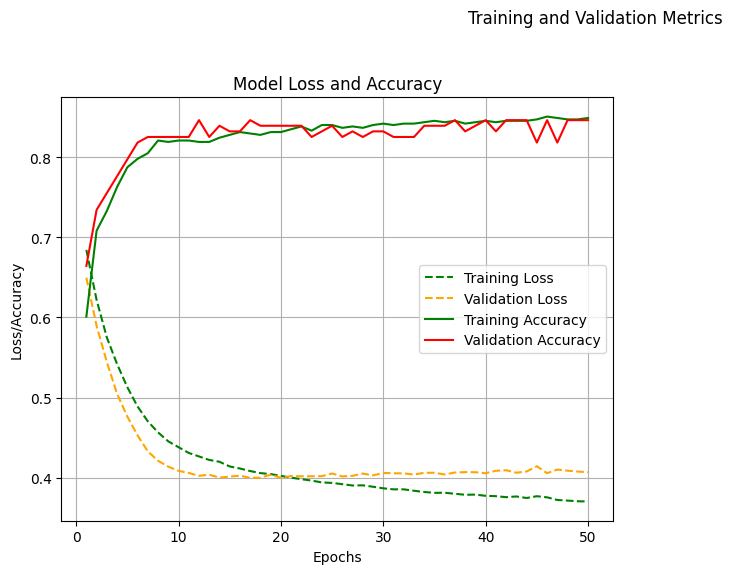

In [ ]:
# Train the model
history01 = model01.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
plot_training_history(history01)

In [ ]:
test_loss01, test_accuracy01 = model01.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy01:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8384 - loss: 0.4172 
Test accuracy: 0.8380


## Let's increase the neurons on our layers

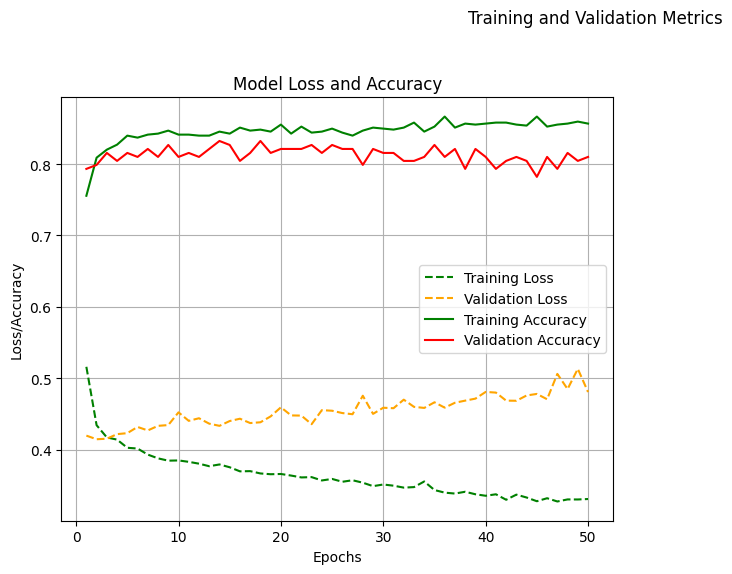

In [ ]:
# Build the neural network model
model02 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
# Compile the model
model02.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history02 = model02.fit(X_train, y_train,
                        epochs=50,
                        batch_size=10,
                        validation_data=(X_test, y_test),
                        verbose=0)
plot_training_history(history02)

In [ ]:
test_loss02, test_accuracy02 = model02.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy02:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8066 - loss: 0.4661 
Test accuracy: 0.8101


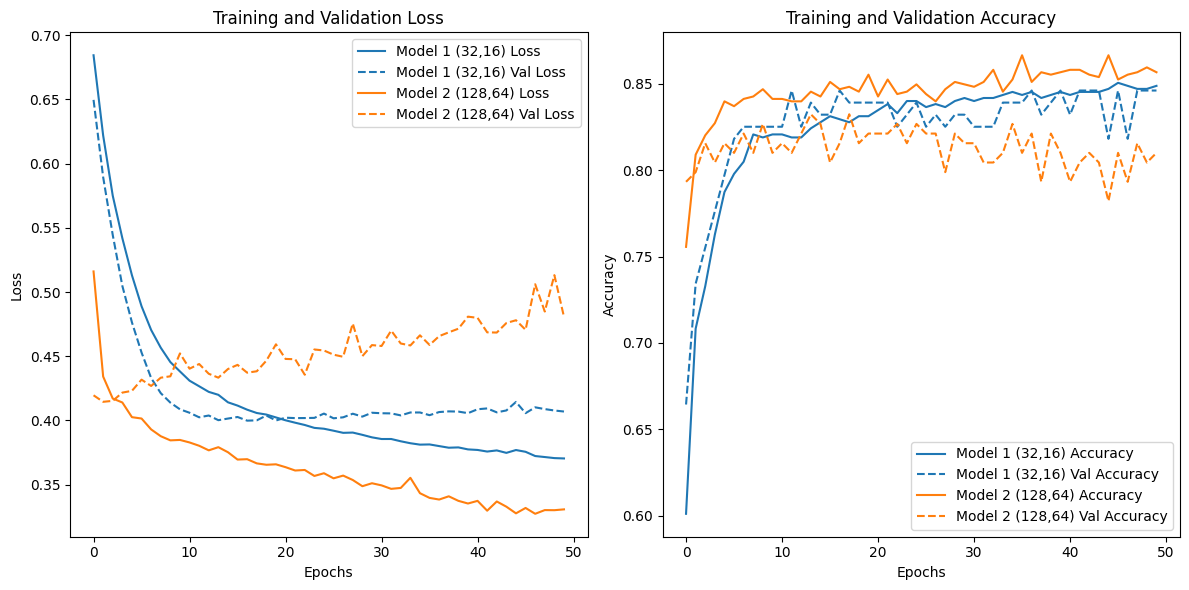

In [ ]:
histories = [history01, history02]
model_names = ['Model 1 (32,16)', 'Model 2 (128,64)']

plot_model_histories(histories, model_names)

## New Model
Let's extend the model. Let's add Dropout layers between the Dense layers.

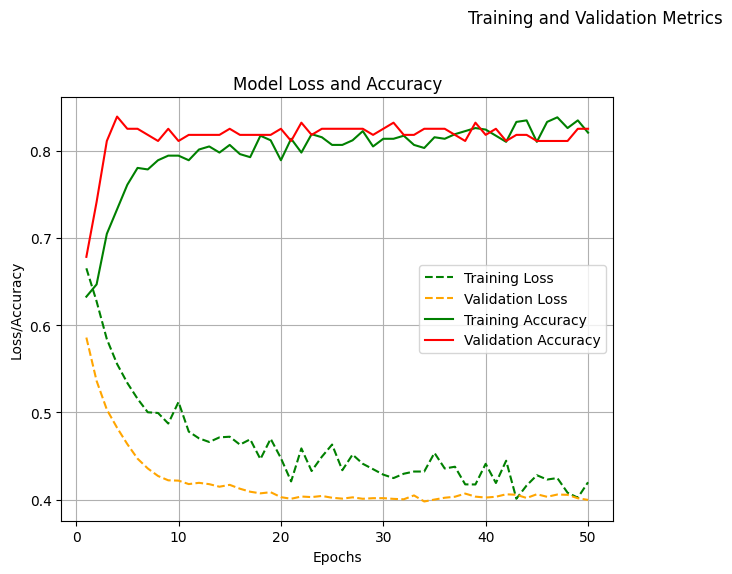

In [ ]:
model03 = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit input layer
    Dense(32, activation='relu'),
    Dropout(0.3),  # Prevent overfitting
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output Layer (binary classification)
])
# Compile the model
model03.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history03 = model03.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2, verbose=0)
plot_training_history(history03)

In [ ]:
test_loss03, test_accuracy03 = model03.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy03:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8111 - loss: 0.4138 
Test accuracy: 0.8101


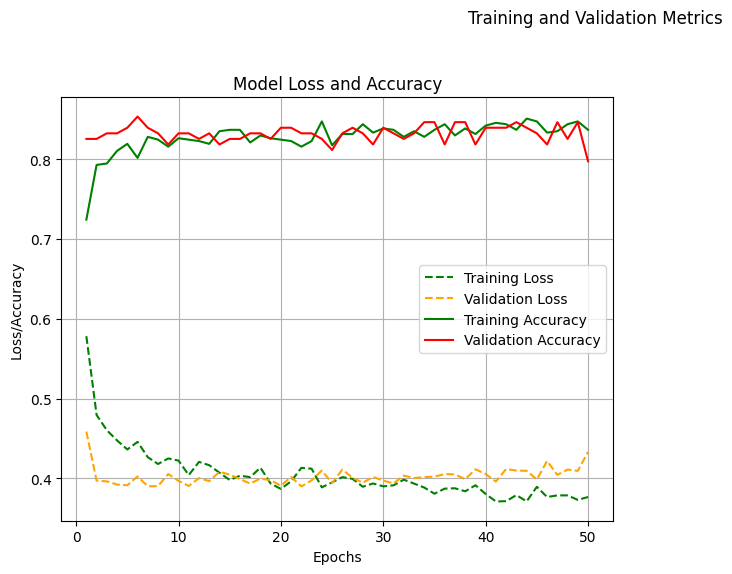

In [ ]:
model04 = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit input layer
    Dense(128, activation='relu'),
    Dropout(0.3),  # Prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output Layer (binary classification)
])
# Compile the model
model04.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history04 = model04.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2, verbose=0)
plot_training_history(history04)

In [ ]:
test_loss04, test_accuracy04 = model04.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy04:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8073 - loss: 0.4258 
Test accuracy: 0.8101


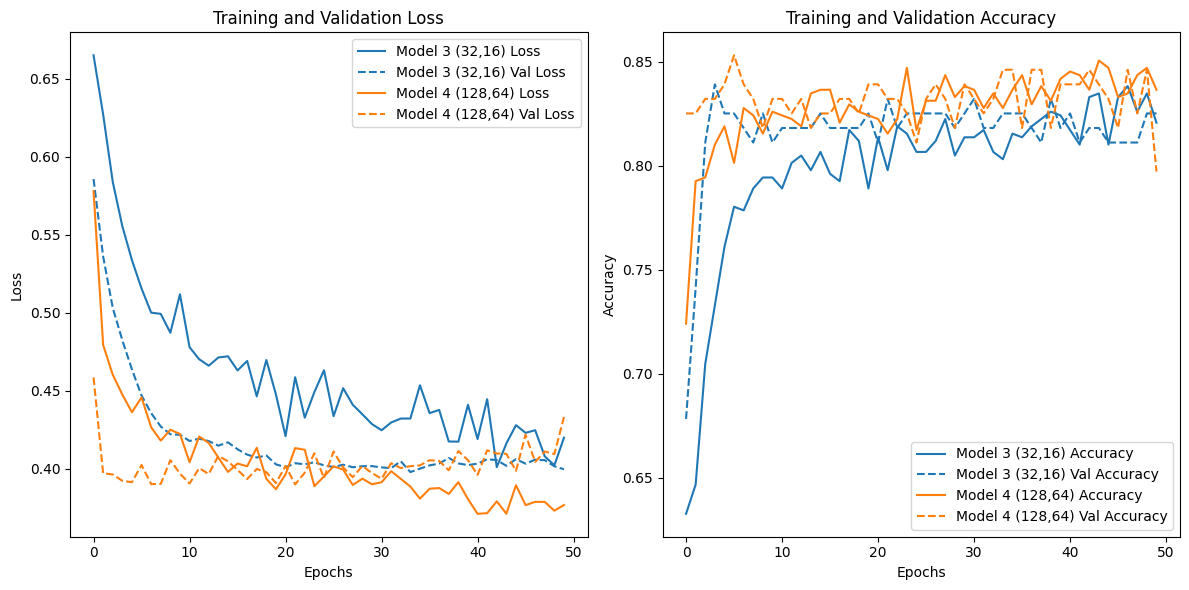

In [ ]:
histories = [history03, history04]
model_names = ['Model 3 (32,16)', 'Model 4 (128,64)']

plot_model_histories(histories, model_names)

## Add more Dense layers

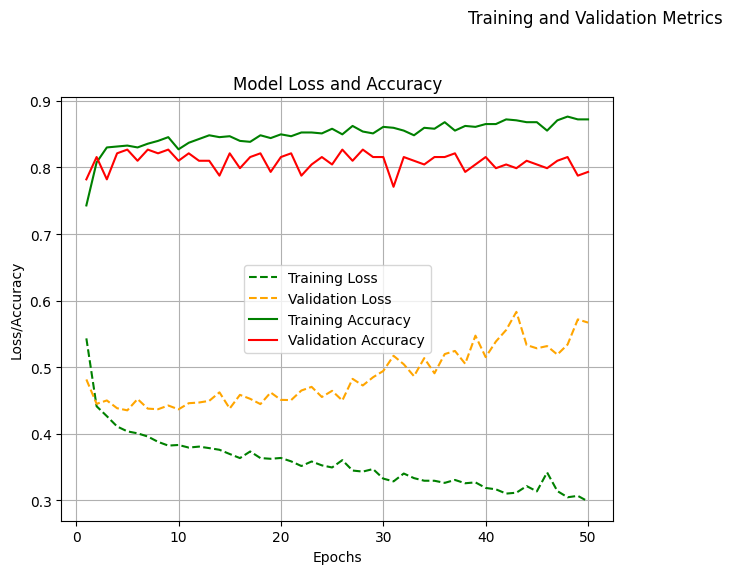

In [ ]:
# Build the neural network model
model05 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
# Compile the model
model05.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history05 = model05.fit(X_train, y_train,
                        epochs=50,
                        batch_size=10,
                        validation_data=(X_test, y_test),
                        verbose=0)
plot_training_history(history05)

In [ ]:
test_loss05, test_accuracy05 = model05.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy05:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7895 - loss: 0.5207 
Test accuracy: 0.7933


These don't seem to have much effect.
We could try hyperparameter tuning or check if there's another model that can give higher scores before tuning.

What's the best performing model so far?

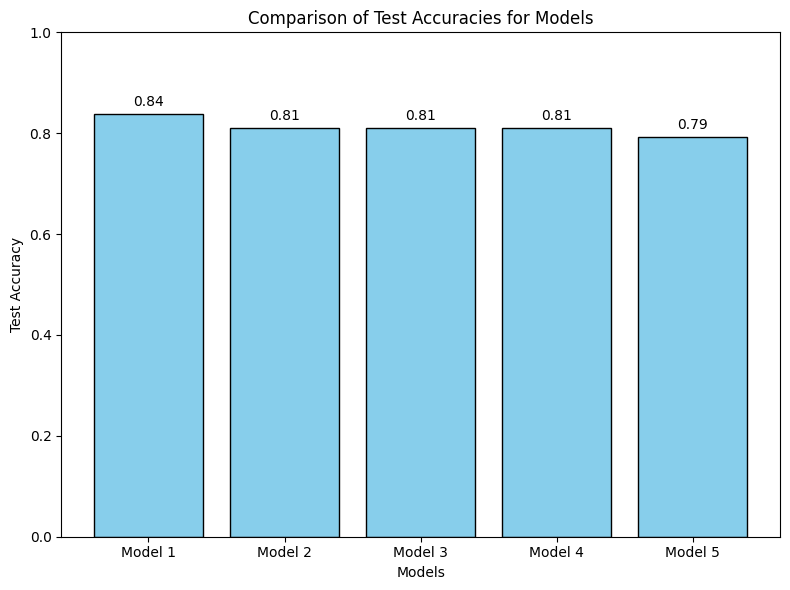

In [ ]:
# Test accuracy values
test_accuracies = [
    test_accuracy01,
    test_accuracy02,
    test_accuracy03,
    test_accuracy04,
    test_accuracy05
]

# Names of the models
model_names = [
    'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'
]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.bar(model_names, test_accuracies, color='skyblue', edgecolor='black')

# Add title and labels
plt.title('Comparison of Test Accuracies for Models')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)  # Assuming test accuracy is between 0 and 1

# Show values on top of the bars
for i, acc in enumerate(test_accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()


## GridSearchCV
Let's find the best performing hyperparameters

In [ ]:
def create_model(optimizer='adam', layers=3, neurons_max=128, activation='relu'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    neurons = neurons_max
    for i in range(layers):
        model.add(Dense(neurons, activation=activation))
        neurons = max(1, neurons // 2)
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model in KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__optimizer': ['adam', 'sgd'],  # Optimizers to try
    'model__neurons_max': [32, 64, 128, 256],  # Max number of neurons in any hidden layer
    'model__layers': [1, 2, 3, 4],         # Number of layers
    'model__activation': ['relu', 'tanh'],# Activation functions
    'batch_size': [16, 32],               # Batch sizes
    'epochs': [10, 20]                    # Number of epochs
}

# Set up GridSearchCV
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=3,
                    verbose=1,
                    scoring='accuracy')

# Perform Grid Search
grid_result = grid.fit(X_train, y_train)


Fitting 3 folds for each of 256 candidates, totalling 768 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
# Print the best parameters and score
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print("Best Hyperparameters:", grid_result.best_params_)

Best Accuracy: 0.8272
Best Hyperparameters: {'batch_size': 16, 'epochs': 20, 'model__activation': 'relu', 'model__layers': 3, 'model__neurons_max': 32, 'model__optimizer': 'adam'}


In [ ]:
# Evaluate on the test set
test_accuracy = grid_result.best_estimator_.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8156


## GridSearchCV on the second architecture

In [ ]:
def create_model(optimizer='adam', layers=3, neurons_max=128, activation='relu', dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    neurons = neurons_max
    for i in range(layers):
        model.add(Dense(neurons, activation=activation)),
        model.add(Dropout(dropout_rate)),
        neurons = max(1, neurons // 2)
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model in KerasClassifier
grid_model2 = KerasClassifier(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid2 = {
    'model__optimizer': ['adam', 'sgd'],  # Optimizers to try
    'model__neurons_max': [32, 64],  # Max number of neurons in any hidden layer
    'model__layers': [3, 4],         # Number of layers
    'model__activation': ['relu', 'tanh'],# Activation functions
    'model__dropout_rate': [0.5, 0.2],  # Dropout rates
    'batch_size': [16, 32],               # Batch sizes
    'epochs': [5, 8]                    # Number of epochs
}

# Set up GridSearchCV
grid2 = GridSearchCV(estimator=grid_model2,
                    param_grid=param_grid2,
                    cv=3,
                    verbose=1,
                    scoring='accuracy')

# Perform Grid Search
grid_result2 = grid2.fit(X_train, y_train)


Fitting 3 folds for each of 128 candidates, totalling 384 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
# Print the best parameters and score
print(f"Best Accuracy: {grid_result2.best_score_:.4f}")
print("Best Hyperparameters:", grid_result2.best_params_)

Best Accuracy: 0.8146
Best Hyperparameters: {'batch_size': 16, 'epochs': 8, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__layers': 3, 'model__neurons_max': 64, 'model__optimizer': 'adam'}


In [ ]:
# Evaluate on the test set
grid_test_accuracy2 = grid_result2.best_estimator_.score(X_test, y_test)
print(f"Test Accuracy: {grid_test_accuracy2:.4f}")

Test Accuracy: 0.8101


## Analysis and Conclusion
The Simple model worked pretty well right of the bat, with high accuracies of over 0.8. However, it didn't improve much over the course of this project. We tuned multiple parameters, increased the layers and layer complexity, but remained unable to meaningfully increase the accuracy of the model.

## Future Work
We were unable to significantly improve on the accuracy results in this project. However, we have some ideas for further optimization, including
* Reduce the number of features. We didn't perform any feature tuning on this project. We may be stuck because of noisy features
* Try replacing missing Age with mean rather than median
* Try to extrapolate titles from Name. This could indicate importance
* Explore combining similar features like Pclass and Fare


In [ ]:
#!kaggle competitions submit -c titanic -f titanic_submission.csv -m "Sample"